In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

import cvlib as cv

#from google.colab.patches import cv2_imshow


2022-02-15 16:01:06.291526: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/bruno/programming/lib/python3.8/site-packages/cv2/../../lib64:
2022-02-15 16:01:06.291553: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import keras 
from keras.layers import *
from keras.models import *
from keras import backend as K

In [42]:
model = keras.models.load_model("data_15-2.h5")

In [4]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data


NameError: name 'x_test' is not defined

In [9]:

class FaceDetector():

    def __init__(self,faceCascadePath):
        self.faceCascade=cv2.CascadeClassifier(cv2.data.haarcascades+faceCascadePath)


    def detect(self, image, scaleFactor=1.1,
               minNeighbors=5,
               minSize=(30,30)):
        
        #function return rectangle coordinates of faces for given image
        rects=self.faceCascade.detectMultiScale(image,
                                                scaleFactor=scaleFactor,
                                                minNeighbors=minNeighbors,
                                                minSize=minSize)
        return list(rects)

In [10]:
#Frontal face of haar cascade loaded
frontal_cascade_path="haarcascade_frontalface_default.xml"

#Detector object created
fd=FaceDetector(frontal_cascade_path)

In [11]:
def show_image(image):
    plt.figure(figsize=(18,15))
    #Before showing image, bgr color order transformed to rgb order
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [12]:

def detect_face(image, scaleFactor, minNeighbors, minSize):
    # face will detected in gray image
    image_gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_crop = []
    
    faces=fd.detect(image_gray,
                   scaleFactor=scaleFactor,
                   minNeighbors=minNeighbors,
                   minSize=minSize)
    
    for (x,y,w,h) in faces:
        #detected faces shown in color image
        #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        img_crop.append(image[y:y+h, x:x+w])

    return faces
    

In [4]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
    
def age_group(age):
    if age >=0 and age < 18:
        return 1
    elif age < 30:
        return 2
    elif age < 80:
        return 3
    else:
        return 4

def get_age(distr):
    distr = distr*4
    if distr >= 0.65 and distr <= 1.4:return "0-18"
    if distr >= 1.65 and distr <= 2.4:return "19-30"
    if distr >= 2.65 and distr <= 3.4:return "31-80"
    if distr >= 3.65 and distr <= 4.4:return "80 +"
    return "Unknown"
    
def get_gender(prob):
    if prob < 0.5:return "Male"
    else: return "Female"

def get_result(sample):
    sample = sample/255
    val = model.predict(sample)
    age = get_age(val[0])
    gender = get_gender(val[1])
    return  f"Gender: {gender} Age Range: {age}"





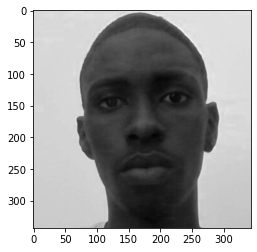

'Gender: Male Age Range: 19-30'

In [10]:
org = cv2.imread("bruno.jpg")
sample = np.copy(org)

display(sample)
face_crop = cv2.cvtColor(sample, cv2.COLOR_RGB2GRAY)
face_crop = cv2.resize(face_crop, (64,64))
face_crop = face_crop.astype("float") / 255.0
face_crop = img_to_array(face_crop)
face_crop = np.expand_dims(face_crop, axis=0)

get_result(face_crop)

Video capture

In [41]:
from tensorflow.keras.preprocessing.image import img_to_array
import cvlib as cv

#face, confidence = cv.detect_face(national_team)

webcam = cv2.VideoCapture(0)

while webcam.isOpened():
    status, frame = webcam.read()
    
    '''face = detect_face(image=frame, 
            scaleFactor=1.2, 
            minNeighbors=5, 
            minSize=(30,30))'''
    
    face, confidence = cv.detect_face(frame)
    

    for (x,y,w,h) in face:
          
        (startX, startY) = x, y
        (endX, endY) = w, h

        # draw rectangle over face
        cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
        #cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    

        # crop the detected face region
        face_crop = np.copy(frame[startY:endY,startX:endX])

        if (face_crop.shape[0]) < 10 or (face_crop.shape[1]) < 10:
            continue
        
        # preprocessing for gender detection model
        face_crop = cv2.cvtColor(face_crop, cv2.COLOR_RGB2GRAY)
        face_crop = cv2.resize(face_crop, (64,64))
        #face_crop = face_crop.astype("float") / 255.0
        face_crop = img_to_array(face_crop)
        face_crop = np.expand_dims(face_crop, axis=0)
        
        # apply gender detection on face
        conf = get_result(face_crop) # model.predict return a 2D matrix, ex: [[9.9993384e-01 7.4850512e-05]]
        # get label with max accuracy
        
        Y = startY - 10 if startY - 10 > 10 else startY + 10

        # write label and confidence above face rectangle
        cv2.putText(frame, conf, (startX, Y),  cv2.FONT_HERSHEY_SIMPLEX,
                   0.7, (0, 255, 0), 2)

    # display output
    cv2.imshow("gender detection", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# release resources
webcam.release()
cv2.destroyAllWindows()


Total samples: 23708
26_1_2_20170116184043483.jpg.chip.jpg


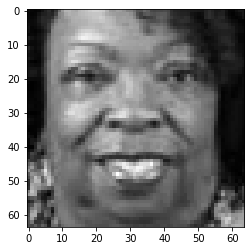

Actual Gender: Female Age: 50
Gender: Female Age Range: 31-80


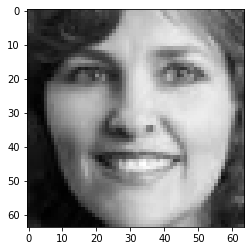

Actual Gender: Female Age: 36
Gender: Female Age Range: 31-80


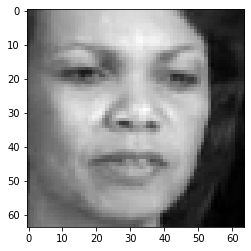

Actual Gender: Female Age: 50
Gender: Female Age Range: 31-80


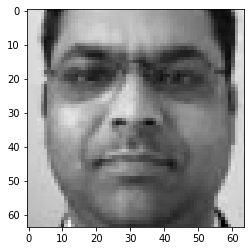

Actual Gender: Male Age: 42
Gender: Male Age Range: 31-80


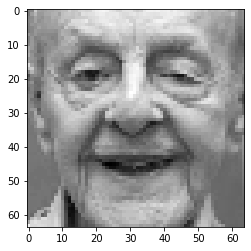

Actual Gender: Male Age: 89
Gender: Male Age Range: Unknown


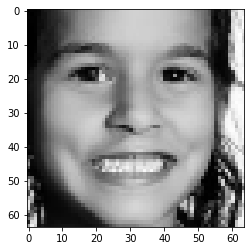

Actual Gender: Female Age: 8
Gender: Female Age Range: 0-18


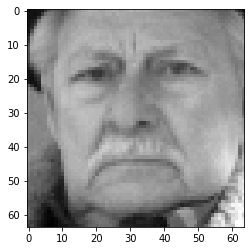

Actual Gender: Male Age: 80
Gender: Male Age Range: Unknown


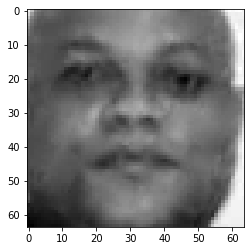

Actual Gender: Male Age: 45
Gender: Male Age Range: 31-80


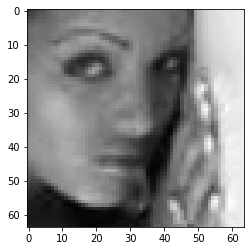

Actual Gender: Female Age: 36
Gender: Female Age Range: 31-80


In [43]:
path = "./UTKFace/"
files = os.listdir(path)
size = len(files)
print("Total samples:",size)
print(files[0])

images = []
ages = []
genders = []
for file in files:
    image = cv2.imread(path+file,0)
    image = cv2.resize(image,dsize=(64,64))
    image = image.reshape((image.shape[0],image.shape[1],1))
    images.append(image)
    split_var = file.split('_')
    ages.append(split_var[0])
    genders.append(int(split_var[1]) )

indexes = [650,859,980,142,454,785,9,26,145]
for idx in indexes:
    sample = images[idx]
    display(sample)
    sample = cv2.resize(sample, (64,64))
    sample = img_to_array(sample)
    sample = np.expand_dims(sample, axis=0)
    
    print("Actual Gender:",get_gender(genders[idx]),"Age:",ages[idx])
    print(get_result(sample))